# descriptive stats on data

- it became clear from the feature engineering and trying to run a simple linear model that the size of the data is cumbersome

- moved from ml.m52xlarget to ml.m5.4xlarge

- the number of observations in the test data is 15 days
- in the training it was 1687 days


- we have established that the items have to be pooled in some way to account for the sparsity of observations for some items
    * at least for all stores and likely by item grouping
   
- model is regression based models , gradient boosted decision trees according to learnings from kaggle forecasting competitions (Bojer and Meldgaard)

- neural networks
    
    

# stratification for modelling
- start with the simplest which is regression by item pooled across store
- indicator for has the item been sold in this store previously


- given time constraints am going to run lstm neural network model 
- with multioutput 
-

reference: 
- https://machinelearningmastery.com/multi-output-regression-models-with-python/ 
- https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/
- https://www.tensorflow.org/tutorials/structured_data/time_series
Chollet

In [123]:
import pandas as pd
import numpy as np

In [124]:
%%time
df_train = pd.read_feather("data/trainpy.feather")
df_test = pd.read_csv("data/test.csv") 

CPU times: user 7.94 s, sys: 6.02 s, total: 14 s
Wall time: 6.08 s


In [125]:
df_train.head()

id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0        None
1   1  2013-01-01         25    105574         1.0        None
2   2  2013-01-01         25    105575         2.0        None
3   3  2013-01-01         25    108079         1.0        None
4   4  2013-01-01         25    108701         1.0        None

In [126]:
train_items = df_train['item_nbr'].unique()
test_items = df_test['item_nbr'].unique()

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
 
items = intersection(train_items, test_items)
len(items)

#https://realpython.com/python-sets/
items_not_in_train = list(set(test_items).difference(train_items))
items_not_in_test = list(set(train_items).difference(test_items))
print("items not in train:", len(items_not_in_train))
print("items not in test (ignore):", len(items_not_in_test))

items not in train: 60
items not in test (ignore): 195


In [127]:
pd.DataFrame(items, columns=['item_nbr']).to_csv("items/items_both.csv", index=False)
pd.DataFrame(items_not_in_train, columns=['item_nbr']).to_csv("items/items_not_in_train.csv", index=False)

In [128]:
from random import sample
item = sample(items,1)[0]
item

1584374

In [129]:
df_train_i = df_train[df_train['item_nbr'] == 1956004]
df_test_i = df_test[df_test['item_nbr'] == 1956004]

print(df_train_i.shape)
data = pd.concat([df_train_i, df_test_i])

#data.to_csv("items/data.csv", index=False)

(11840, 6)


In [130]:
#data = pd.read_csv("items/data.csv")

data.shape
len(data['store_nbr'].unique())
data

id        date  store_nbr  item_nbr  unit_sales onpromotion
67433669   67433669  2016-01-12          7   1956004         4.0       False
67613006   67613006  2016-01-14          7   1956004         6.0       False
67638493   67638493  2016-01-14         24   1956004         6.0       False
67675626   67675626  2016-01-14         47   1956004         5.0       False
67701435   67701435  2016-01-15          7   1956004         2.0       False
...             ...         ...        ...       ...         ...         ...
3354062   128851102  2017-08-31         50   1956004         NaN       False
3357963   128855003  2017-08-31         51   1956004         NaN        True
3361864   128858904  2017-08-31         52   1956004         NaN        True
3365765   128862805  2017-08-31         53   1956004         NaN       False
3369666   128866706  2017-08-31         54   1956004         NaN       False

[12704 rows x 6 columns]

In [131]:
dt = data.pivot(values='unit_sales', index=['date'], columns='store_nbr')
dt.shape
dt.shape[0] * dt.shape[1]

32130

In [132]:
df = dt.fillna(0)
print(df.columns)
df.index = pd.to_datetime(df.index)
df

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54],
           dtype='int64', name='store_nbr')


store_nbr    1    2    3    4    5    6    7    8    9    10  ...   45   46  \
date                                                          ...             
2016-01-12  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-14  0.0  0.0  0.0  0.0  0.0  0.0  6.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-15  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-16  0.0  0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-17  0.0  0.0  7.0  0.0  4.0  0.0  2.0  0.0  0.0  0.0  ...  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-08-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

store_nbr    47   48   49   50   51   52   53   54  
date                                                
2016-01-12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-14  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-15  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-16  4.0  6.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-17  6.0  9.0  0.0  0.0  0.0  0.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  
2017-08-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[595 rows x 54 columns]

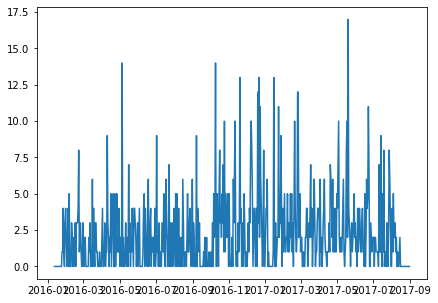

In [133]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))


plt.plot(df[1].index, df[1].values)

In [134]:
from datetime import datetime 
cutoff = datetime.strptime('2017-08-16', "%Y-%m-%d")
df1 = df.loc[df.index < cutoff, :]

#keep last 50 rows for final prediction, test set for submission
dfh = df1[-50:]
dfh.tail()

store_nbr    1    2     3    4    5    6    7    8    9    10  ...   45    46  \
date                                                           ...              
2017-08-11  1.0  2.0  19.0  0.0  1.0  5.0  2.0  0.0  0.0  0.0  ...  6.0  21.0   
2017-08-12  0.0  1.0  17.0  0.0  2.0  2.0  0.0  0.0  0.0  0.0  ...  9.0  11.0   
2017-08-13  0.0  7.0   8.0  0.0  2.0  6.0  0.0  3.0  0.0  0.0  ...  9.0  26.0   
2017-08-14  1.0  3.0   7.0  0.0  1.0  4.0  0.0  1.0  0.0  0.0  ...  9.0  18.0   
2017-08-15  2.0  1.0  10.0  0.0  2.0  7.0  1.0  3.0  0.0  0.0  ...  1.0  23.0   

store_nbr     47    48   49   50   51    52   53   54  
date                                                   
2017-08-11   8.0  10.0  2.0  0.0  5.0  10.0  0.0  0.0  
2017-08-12  11.0  14.0  4.0  0.0  3.0  13.0  0.0  0.0  
2017-08-13   9.0  13.0  3.0  0.0  6.0  19.0  0.0  0.0  
2017-08-14  10.0   8.0  3.0  0.0  4.0   6.0  0.0  0.0  
2017-08-15   2.0  15.0  3.0  0.0  5.0  12.0  0.0  0.0  

[5 rows x 54 columns]

In [135]:
dfv = df1.values
print(dfv.shape)
dfv

(579, 54)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  7.,  8., ..., 19.,  0.,  0.],
       [ 1.,  3.,  7., ...,  6.,  0.,  0.],
       [ 2.,  1., 10., ..., 12.,  0.,  0.]])

In [136]:
df1

store_nbr    1    2     3    4    5    6    7    8    9    10  ...   45    46  \
date                                                           ...              
2016-01-12  0.0  0.0   0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  ...  0.0   0.0   
2016-01-14  0.0  0.0   0.0  0.0  0.0  0.0  6.0  0.0  0.0  0.0  ...  0.0   0.0   
2016-01-15  0.0  0.0   0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  ...  0.0   0.0   
2016-01-16  0.0  0.0   0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  ...  0.0   0.0   
2016-01-17  0.0  0.0   7.0  0.0  4.0  0.0  2.0  0.0  0.0  0.0  ...  0.0   0.0   
...         ...  ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
2017-08-11  1.0  2.0  19.0  0.0  1.0  5.0  2.0  0.0  0.0  0.0  ...  6.0  21.0   
2017-08-12  0.0  1.0  17.0  0.0  2.0  2.0  0.0  0.0  0.0  0.0  ...  9.0  11.0   
2017-08-13  0.0  7.0   8.0  0.0  2.0  6.0  0.0  3.0  0.0  0.0  ...  9.0  26.0   
2017-08-14  1.0  3.0   7.0  0.0  1.0  4.0  0.0  1.0  0.0  0.0  ...  9.0  18.0   
2017-08-15  2.0  1.0  10.0  0.0  2.0  7.0  1.0  3.0  0.0  0.0  ...  1.0  23.0   

store_nbr     47    48   49   50   51    52   53   54  
date                                                   
2016-01-12   0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2016-01-14   5.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2016-01-15   2.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2016-01-16   4.0   6.0  0.0  0.0  0.0   0.0  0.0  0.0  
2016-01-17   6.0   9.0  0.0  0.0  0.0   0.0  0.0  0.0  
...          ...   ...  ...  ...  ...   ...  ...  ...  
2017-08-11   8.0  10.0  2.0  0.0  5.0  10.0  0.0  0.0  
2017-08-12  11.0  14.0  4.0  0.0  3.0  13.0  0.0  0.0  
2017-08-13   9.0  13.0  3.0  0.0  6.0  19.0  0.0  0.0  
2017-08-14  10.0   8.0  3.0  0.0  4.0   6.0  0.0  0.0  
2017-08-15   2.0  15.0  3.0  0.0  5.0  12.0  0.0  0.0  

[579 rows x 54 columns]

In [137]:
from datetime import datetime 
cutoff = datetime.strptime('2017-08-16', "%Y-%m-%d")
dff = df.loc[df.index >= cutoff, :]
dff

store_nbr    1    2    3    4    5    6    7    8    9    10  ...   45   46  \
date                                                          ...             
2017-08-16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-25  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-26  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

store_nbr    47   48   49   50   51   52   53   54  
date                                                
2017-08-16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-25  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-26  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[16 rows x 54 columns]

In [138]:
dtref_dates = dff.index
dtref_dates

DatetimeIndex(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
               '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', name='date', freq=None)

In [139]:
dfhf = pd.concat([dfh, dff])
print(dfhf.shape)
dfhf

(66, 54)


store_nbr    1     2    3    4    5    6    7     8    9    10  ...   45  \
date                                                            ...        
2017-06-27  3.0   4.0  1.0  0.0  0.0  3.0  0.0   5.0  0.0  0.0  ...  4.0   
2017-06-28  2.0   1.0  7.0  0.0  1.0  1.0  2.0   1.0  0.0  0.0  ...  9.0   
2017-06-29  1.0  10.0  6.0  0.0  3.0  0.0  0.0   1.0  0.0  0.0  ...  3.0   
2017-06-30  2.0   3.0  3.0  0.0  0.0  1.0  1.0   0.0  0.0  0.0  ...  7.0   
2017-07-01  2.0   2.0  9.0  0.0  0.0  1.0  2.0  16.0  0.0  0.0  ...  5.0   
...         ...   ...  ...  ...  ...  ...  ...   ...  ...  ...  ...  ...   
2017-08-27  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0   
2017-08-28  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0   
2017-08-29  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0   
2017-08-30  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0   
2017-08-31  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0   

store_nbr     46    47    48   49   50   51    52   53   54  
date                                                         
2017-06-27   8.0   7.0   9.0  1.0  0.0  0.0   2.0  0.0  0.0  
2017-06-28   8.0  14.0   7.0  3.0  0.0  6.0  14.0  0.0  0.0  
2017-06-29   6.0  10.0   6.0  3.0  0.0  7.0   3.0  0.0  0.0  
2017-06-30   6.0   2.0  16.0  2.0  0.0  5.0   9.0  0.0  0.0  
2017-07-01  10.0  13.0  16.0  1.0  0.0  7.0   2.0  0.0  0.0  
...          ...   ...   ...  ...  ...  ...   ...  ...  ...  
2017-08-27   0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2017-08-28   0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2017-08-29   0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2017-08-30   0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2017-08-31   0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  

[66 rows x 54 columns]

In [140]:
dff = dff.values
print(dff.shape)
dff

(16, 54)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
    

In [141]:
"""
start_index: usually 0
end_index: Train Split
history_size: window (lags)
target_size: how far into future
"""

'\nstart_index: usually 0\nend_index: Train Split\nhistory_size: window (lags)\ntarget_size: how far into future\n'

In [142]:
# inspect first value in for loop below
# data[i-lags:i]
dfv[50-50:50]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 3.,  0., 13., ...,  0.,  1.,  0.],
       [ 1.,  1.,  3., ...,  0.,  0.,  0.],
       [ 0.,  1.,  4., ...,  0.,  0.,  0.]])

In [143]:
def create_data_v(data, lags, start, end, target_size):
  x_data = []
  y_data = [] 
  index = [i for i in range(0, len(data))]

  for i in range(start, end):
    x_data.append(data[i-lags:i])
    y_data.append(data[i:i+target_size])
    if (i < start + 5) or (i >= end - 5):
      print("i: %s (%s), x: %s-%s, y: %s-%s" % (i, dt.index[index[i]], i-lags, i-1, i, i+target_size))

  print(f"start: {start}, end: {end}, lags: {lags}, target_size {target_size}")
  return(np.array(x_data), np.array(y_data))

In [144]:
#taking a split of 80/20
split = int(len(dfv) * 0.8)
split

463

In [145]:
# create data for X and y train 

lags = 50
start = lags
end = split
target_size = 16

X_train, y_train = create_data_v(dfv, lags, start, end, target_size)

i: 50 (2016-03-03), x: 0-49, y: 50-66
i: 51 (2016-03-04), x: 1-50, y: 51-67
i: 52 (2016-03-05), x: 2-51, y: 52-68
i: 53 (2016-03-06), x: 3-52, y: 53-69
i: 54 (2016-03-07), x: 4-53, y: 54-70
i: 458 (2017-04-17), x: 408-457, y: 458-474
i: 459 (2017-04-18), x: 409-458, y: 459-475
i: 460 (2017-04-19), x: 410-459, y: 460-476
i: 461 (2017-04-20), x: 411-460, y: 461-477
i: 462 (2017-04-21), x: 412-461, y: 462-478
start: 50, end: 463, lags: 50, target_size 16


In [146]:
y_train.shape
X_train.shape

(413, 50, 54)

In [147]:
# create data for X and y test sets

start = split
end = len(dfv) - target_size

X_test, y_test = create_data_v(dfv, lags, start, end, target_size)

i: 463 (2017-04-22), x: 413-462, y: 463-479
i: 464 (2017-04-23), x: 414-463, y: 464-480
i: 465 (2017-04-24), x: 415-464, y: 465-481
i: 466 (2017-04-25), x: 416-465, y: 466-482
i: 467 (2017-04-26), x: 417-466, y: 467-483
i: 558 (2017-07-26), x: 508-557, y: 558-574
i: 559 (2017-07-27), x: 509-558, y: 559-575
i: 560 (2017-07-28), x: 510-559, y: 560-576
i: 561 (2017-07-29), x: 511-560, y: 561-577
i: 562 (2017-07-30), x: 512-561, y: 562-578
start: 463, end: 563, lags: 50, target_size 16


In [148]:
print(y_test.shape)
print(X_test.shape)

(100, 16, 54)
(100, 50, 54)


In [149]:
print(X_train.shape[0])
X_train[0].shape[0]

print(y_train.shape)
print(X_train.shape)
#y_train.reshape(1, -1)[0].shape
print(X_test.shape)
print(y_test.shape)

413
(413, 16, 54)
(413, 50, 54)
(100, 50, 54)
(100, 16, 54)


In [150]:
xt = pd.DataFrame()
yt = pd.DataFrame()

for i in range(0, X_train.shape[0]):
    xt = xt.append(pd.DataFrame(X_train[i].T))
    yt = yt.append(pd.DataFrame(y_train[i].T))

print(xt.shape)
print(yt.shape)


(22302, 50)
(22302, 16)


In [151]:
xt.shape[0] * xt.shape[1]

1115100

In [152]:
import sklearn.linear_model as lm
m1= lm.LinearRegression()
m1.fit(xt, yt)

LinearRegression()

In [153]:
xtt = pd.DataFrame()
ytt = pd.DataFrame()

predictions = list()

for i in range(0, X_test.shape[0]):
    xtt = xtt.append(pd.DataFrame(X_test[i].T))
    ytt = ytt.append(pd.DataFrame(y_test[i].T))

    
print(xtt.shape)
print(ytt.shape)

preds = m1.predict(xtt)

preds

(5400, 50)
(5400, 16)


array([[3.45532807, 2.66895892, 2.72166743, ..., 3.00468838, 2.72881763,
        2.35877601],
       [3.2662842 , 3.98986494, 2.79220801, ..., 2.34900344, 3.12508922,
        3.90135481],
       [9.09272241, 9.19393608, 7.76847745, ..., 8.873094  , 8.82470502,
        9.4756888 ],
       ...,
       [9.33782076, 7.55716805, 6.00198242, ..., 8.46421225, 8.73547086,
        7.67551459],
       [0.05280362, 0.05344811, 0.06281501, ..., 0.09321003, 0.11934546,
        0.11196207],
       [0.04577267, 0.05577353, 0.06287951, ..., 0.09463446, 0.09958854,
        0.10322819]])

In [154]:
print(preds.shape)
ytt.shape

(5400, 16)


(5400, 16)

In [155]:
pdf = pd.DataFrame(preds)
pdf

0         1         2         3         4         5         6   \
0     3.455328  2.668959  2.721667  2.631912  2.210616  2.803931  2.957300   
1     3.266284  3.989865  2.792208  1.722440  1.961441  2.190702  2.562211   
2     9.092722  9.193936  7.768477  6.660914  7.966974  7.451388  8.819107   
3     6.849252  7.446820  4.645374  3.489023  5.346633  4.758837  4.142443   
4     1.179919  0.845916  0.556742  0.859988  1.347471  1.347085  1.297165   
...        ...       ...       ...       ...       ...       ...       ...   
5395  0.045773  0.055774  0.062880  0.068083  0.071156  0.075014  0.075807   
5396  4.112083  3.735749  3.596459  5.137023  5.040888  4.868146  5.010896   
5397  9.337821  7.557168  6.001982  5.967608  5.839864  7.636820  9.356521   
5398  0.052804  0.053448  0.062815  0.061770  0.131617  0.100041  0.062182   
5399  0.045773  0.055774  0.062880  0.068083  0.071156  0.075014  0.075807   

            7         8         9         10        11        12        13  \
0     2.802374  2.189653  2.508346  2.307035  2.171869  2.795267  3.004688   
1     2.893038  3.957225  2.222381  1.448782  1.579875  2.701089  2.349003   
2     8.647117  9.509717  7.227113  6.395967  8.081599  8.016411  8.873094   
3     7.177820  7.591870  4.544955  3.702256  4.979834  4.847002  4.256472   
4     1.149276  1.067563  0.759382  0.824695  1.426642  1.550484  1.377210   
...        ...       ...       ...       ...       ...       ...       ...   
5395  0.082159  0.086689  0.089398  0.090569  0.092658  0.094171  0.094634   
5396  4.297258  3.849640  3.508458  6.047648  5.220744  4.664878  5.013350   
5397  8.102728  7.755650  5.898786  6.402928  5.875168  7.732793  8.464212   
5398  0.088819  0.112199  0.100980  0.117412  0.165172  0.120912  0.093210   
5399  0.082159  0.086689  0.089398  0.090569  0.092658  0.094171  0.094634   

            14        15  
0     2.728818  2.358776  
1     3.125089  3.901355  
2     8.824705  9.475689  
3     6.801305  6.990246  
4     1.210424  1.083362  
...        ...       ...  
5395  0.099589  0.103228  
5396  4.388646  2.859278  
5397  8.735471  7.675515  
5398  0.119345  0.111962  
5399  0.099589  0.103228  

[5400 rows x 16 columns]

In [156]:
ytt

0     1    2    3     4     5    6     7     8    9    10    11    12  \
0    5.0   2.0  6.0  1.0   4.0   1.0  1.0   4.0   1.0  5.0  4.0   7.0  10.0   
1    5.0   1.0  2.0  0.0   4.0   2.0  2.0   1.0   1.0  3.0  1.0  11.0   1.0   
2    9.0  11.0  3.0  1.0   1.0  11.0  4.0   2.0   5.0  7.0  7.0  19.0   3.0   
3    5.0   5.0  8.0  7.0  12.0   3.0  1.0   3.0   4.0  4.0  4.0   6.0   4.0   
4    1.0   0.0  0.0  0.0   0.0   0.0  0.0   3.0   4.0  0.0  0.0   3.0   0.0   
..   ...   ...  ...  ...   ...   ...  ...   ...   ...  ...  ...   ...   ...   
49   0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   
50   6.0   4.0  1.0  8.0   1.0   7.0  5.0   6.0   3.0  6.0  7.0   4.0   5.0   
51  14.0   8.0  8.0  4.0  11.0   9.0  7.0  11.0  11.0  8.0  8.0   5.0  10.0   
52   0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   
53   0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   

      13    14    15  
0    2.0   1.0   1.0  
1    2.0   4.0   8.0  
2    5.0   5.0  13.0  
3    0.0  12.0   6.0  
4    3.0   0.0   0.0  
..   ...   ...   ...  
49   0.0   0.0   0.0  
50   3.0   6.0   4.0  
51  13.0  19.0   6.0  
52   0.0   0.0   0.0  
53   0.0   0.0   0.0  

[5400 rows x 16 columns]

In [157]:
np.mean(np.abs(pdf.values - ytt.values))

1.434026144768179

In [158]:
eval1 = np.sqrt(np.mean(np.square(np.log(pdf.values + 1) - np.log(ytt.values + 1))))
eval1

0.5500293364619915

In [159]:
from sklearn.tree import DecisionTreeRegressor

m2 = DecisionTreeRegressor()
m2.fit(xt, yt)

preds = m2.predict(xtt)

preds
pdf = pd.DataFrame(preds)
np.mean(np.abs(pdf.values - ytt.values))

2.0119392366581934

In [160]:
eval2 = np.sqrt(np.mean(np.square(np.log(pdf.values + 1) - np.log(ytt.values + 1))))
eval2

0.7467388274797734

In [161]:
print(len(dfhf),lags)

66 50


In [162]:
# create data for X and y final test 

lags = 50
start = lags
end = 51
target_size = 16

X_testf, y_testf = create_data_v(dfhf, lags, start, end, target_size)

i: 50 (2016-03-03), x: 0-49, y: 50-66
start: 50, end: 51, lags: 50, target_size 16


In [163]:
print(X_testf.shape)
print(y_testf.shape)

(1, 50, 54)
(1, 16, 54)


In [164]:
xtf = pd.DataFrame()
ytf = pd.DataFrame()

predictions = list()

for i in range(0, X_testf.shape[0]):
    xtf = xtf.append(pd.DataFrame(X_testf[i].T))
    
print("xtf shape:", xtf.shape)

if eval1 < eval2:
    predsf = m1.predict(xtf)
else:
    predsf = m2.predict(xtf)

xtf shape: (54, 50)


In [165]:
print(predsf.shape)
ptf = pd.DataFrame(predsf)
ptf.tail()

(54, 16)


0         1         2          3          4         5         6   \
49  0.045773  0.055774  0.062880   0.068083   0.071156  0.075014  0.075807   
50  6.059674  5.230404  4.158586   4.994288   4.979609  4.095748  4.053229   
51  7.889497  8.171467  9.281555  10.007679  10.270694  8.862290  6.882297   
52  0.067941  0.098563  0.053632   0.055579   0.075144  0.060637  0.060833   
53  0.045773  0.055774  0.062880   0.068083   0.071156  0.075014  0.075807   

          7         8         9         10         11        12        13  \
49  0.082159  0.086689  0.089398  0.090569   0.092658  0.094171  0.094634   
50  5.468677  5.217650  4.404800  4.704685   5.019278  4.267141  4.246551   
51  8.126786  7.158719  9.179161  8.979035  10.513328  8.385494  7.663798   
52  0.086562  0.134299  0.105377  0.074602   0.100762  0.081038  0.118310   
53  0.082159  0.086689  0.089398  0.090569   0.092658  0.094171  0.094634   

          14        15  
49  0.099589  0.103228  
50  5.803832  5.078012  
51  7.209821  7.325081  
52  0.092566  0.160835  
53  0.099589  0.103228

In [172]:
ptf = ptf.rename(columns={0:'t0',1:'t1',2:'t2',3:'t3',4:'t4',5:'t5',6:'t6',7:'t7',8:'t8',9:'t9',10:'t10',11:'t11',12:'t12',13:'t13',14:'t14',15:'t15'})
ptf.tail()

t0        t1        t2         t3         t4        t5        t6  \
49  0.045773  0.055774  0.062880   0.068083   0.071156  0.075014  0.075807   
50  6.059674  5.230404  4.158586   4.994288   4.979609  4.095748  4.053229   
51  7.889497  8.171467  9.281555  10.007679  10.270694  8.862290  6.882297   
52  0.067941  0.098563  0.053632   0.055579   0.075144  0.060637  0.060833   
53  0.045773  0.055774  0.062880   0.068083   0.071156  0.075014  0.075807   

          t7        t8        t9       t10        t11       t12       t13  \
49  0.082159  0.086689  0.089398  0.090569   0.092658  0.094171  0.094634   
50  5.468677  5.217650  4.404800  4.704685   5.019278  4.267141  4.246551   
51  8.126786  7.158719  9.179161  8.979035  10.513328  8.385494  7.663798   
52  0.086562  0.134299  0.105377  0.074602   0.100762  0.081038  0.118310   
53  0.082159  0.086689  0.089398  0.090569   0.092658  0.094171  0.094634   

         t14       t15  store  
49  0.099589  0.103228     50  
50  5.803832  5.078012     51  
51  7.209821  7.325081     52  
52  0.092566  0.160835     53  
53  0.099589  0.103228     54

In [173]:
ptf['store'] = [i + 1 for i in range(0, ptf.shape[0])]
ptf.tail()



t0        t1        t2         t3         t4        t5        t6  \
49  0.045773  0.055774  0.062880   0.068083   0.071156  0.075014  0.075807   
50  6.059674  5.230404  4.158586   4.994288   4.979609  4.095748  4.053229   
51  7.889497  8.171467  9.281555  10.007679  10.270694  8.862290  6.882297   
52  0.067941  0.098563  0.053632   0.055579   0.075144  0.060637  0.060833   
53  0.045773  0.055774  0.062880   0.068083   0.071156  0.075014  0.075807   

          t7        t8        t9       t10        t11       t12       t13  \
49  0.082159  0.086689  0.089398  0.090569   0.092658  0.094171  0.094634   
50  5.468677  5.217650  4.404800  4.704685   5.019278  4.267141  4.246551   
51  8.126786  7.158719  9.179161  8.979035  10.513328  8.385494  7.663798   
52  0.086562  0.134299  0.105377  0.074602   0.100762  0.081038  0.118310   
53  0.082159  0.086689  0.089398  0.090569   0.092658  0.094171  0.094634   

         t14       t15  store  
49  0.099589  0.103228     50  
50  5.803832  5.078012     51  
51  7.209821  7.325081     52  
52  0.092566  0.160835     53  
53  0.099589  0.103228     54

In [168]:
dtref = pd.DataFrame(dtref_dates)
dtref['dtindex'] = dtref.index
dtref

date  dtindex
0  2017-08-16        0
1  2017-08-17        1
2  2017-08-18        2
3  2017-08-19        3
4  2017-08-20        4
5  2017-08-21        5
6  2017-08-22        6
7  2017-08-23        7
8  2017-08-24        8
9  2017-08-25        9
10 2017-08-26       10
11 2017-08-27       11
12 2017-08-28       12
13 2017-08-29       13
14 2017-08-30       14
15 2017-08-31       15

In [174]:
rf = pd.wide_to_long(ptf, 't', i='store', j="dtindex")
rf = rf.rename(columns={'t':'unit_sales'})
rf.reset_index(level=['store','dtindex'], inplace=True)
rf

m = pd.merge(rf, dtref, how='left', on='dtindex')
m.drop(columns='dtindex', inplace=True)
m['item_nbr'] = item
m.to_csv("output/%s.csv" % item, index=False)
m

store  unit_sales       date  item_nbr
0        1    1.753179 2017-08-16   1584374
1        2    2.300230 2017-08-16   1584374
2        3    8.125502 2017-08-16   1584374
3        4    0.447285 2017-08-16   1584374
4        5    1.300564 2017-08-16   1584374
..     ...         ...        ...       ...
859     50    0.103228 2017-08-31   1584374
860     51    5.078012 2017-08-31   1584374
861     52    7.325081 2017-08-31   1584374
862     53    0.160835 2017-08-31   1584374
863     54    0.103228 2017-08-31   1584374

[864 rows x 4 columns]